In [1]:
#Set charts to view inline;(directive '%')
%matplotlib inline
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from sklearn import preprocessing as prep
from datetime import datetime

import warnings
##suppress all warnings
warnings.filterwarnings("ignore")

#### Index by CaseNumber  && Cleaning 'DeathLoc' coordinates 

In [2]:
ADRD = 'Accidental_Drug_Related_Deaths__2012-2017.csv'
ORTA ='Opioid_Related_Treatment_Admissions_by_Town_in_Department_of_Mental_Health_and_Addiction_Services_Programs.csv'
AHBT = 'Affordable_Housing_by_Town_2011-Present.csv'
data = pd.read_csv(AHBT)

df = pd.read_csv(ADRD, index_col='CaseNumber',parse_dates=['Date'])

#list comprehension:
df['DeathLoc'] = [i.split("\n") for i in df['DeathLoc']]
df['DeathLoc'] =[i[1].strip('()').split(',') for i in df['DeathLoc']]
df.head()

,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,Death County,...,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
CaseNumber,,,,,,,,,,,,,,,,,,,,,
13-16336,2013-11-09,Female,White,53.0,GROTON,NaN,NEW LONDON,GROTON,NaN,NEW LONDON,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"[41.343693, -72.07877]"
12-18447,2012-12-29,Male,White,30.0,WOLCOTT,NaN,NEW HAVEN,WATERBURY,NaN,NEW HAVEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"[41.554261, -73.043069]"
14-2758,2014-02-18,Male,White,43.0,ENFIELD,NaN,NaN,ENFIELD,NaN,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"[41.976501, -72.591985]"
14-13497,2014-09-07,Female,White,24.0,WALLINGFORD,NaN,NaN,WALLINGFORD,NaN,NEW HAVEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"[41.454408, -72.818414]"
13-14421,2013-10-04,Female,White,26.0,WEST HAVEN,NaN,NEW HAVEN,WEST HAVEN,NaN,NEW HAVEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"[41.272336, -72.949817]"


<br><br>
#### Cleaning and mapping data

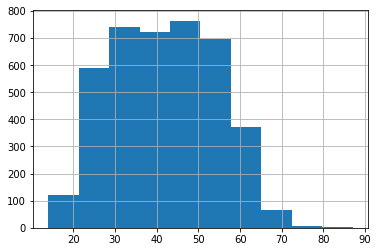

In [3]:
df['Age'].hist()
#skewed right:
df['Age'].fillna(df['Age'].median(), inplace = True)

In [4]:
drugList = [
'Heroin',
'Cocaine',              
'Fentanyl',               
'Oxycodone',                 
'Oxymorphone',               
'EtOH',                     
'Hydrocodone',              
'Benzodiazepine',           
'Methadone',                 
'Amphet',                    
'Tramad'
]


df['Gender_Dummy'] = df.Sex.map({'Male': 0, 'Female': 1})

# an issue arrised with fillna(0) producing a value that was seen to the mapper as NaN.
# solution: fillna('N') and assign back to column. mapping works properly.
for drug in drugList:
    print(drug)
    df[drug] = df[drug].fillna('N')
    df[drug + "_Mapped"] = pd.Series(df[drug]).map({'Y': 1, 'y': 1, 'N': 0, np.nan: 0})



Heroin
Cocaine
Fentanyl
Oxycodone
Oxymorphone
EtOH
Hydrocodone
Benzodiazepine
Methadone
Amphet
Tramad



### Building a Matrices for Race AND Cleaning up column headers (", ")

In [5]:
# df.groupby('Race').agg('count')

In [6]:
race_dummies = pd.get_dummies(df.Race, prefix='race')
## list comprehension to replace column headers with space and comma
race_dummies.columns = [col.replace(', ', '_') for col in race_dummies.columns]
race_dummies.head()

,race_Asian Indian,race_Asian_Other,race_Black,race_Chinese,race_Hawaiian,race_Hispanic_Black,race_Hispanic_White,race_Native American_Other,race_Other,race_Unknown,race_White
CaseNumber,,,,,,,,,,,
13-16336,0,0,0,0,0,0,0,0,0,0,1
12-18447,0,0,0,0,0,0,0,0,0,0,1
14-2758,0,0,0,0,0,0,0,0,0,0,1
14-13497,0,0,0,0,0,0,0,0,0,0,1
13-14421,0,0,0,0,0,0,0,0,0,0,1


In [7]:
# concatenate the dummy variable columns onto the DataFrame (axis=0 means rows, axis=1 means columns)
df = pd.concat([df, race_dummies], axis=1)
df.head()

,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,Death County,...,race_Asian_Other,race_Black,race_Chinese,race_Hawaiian,race_Hispanic_Black,race_Hispanic_White,race_Native American_Other,race_Other,race_Unknown,race_White
CaseNumber,,,,,,,,,,,,,,,,,,,,,
13-16336,2013-11-09,Female,White,53.0,GROTON,NaN,NEW LONDON,GROTON,NaN,NEW LONDON,...,0,0,0,0,0,0,0,0,0,1
12-18447,2012-12-29,Male,White,30.0,WOLCOTT,NaN,NEW HAVEN,WATERBURY,NaN,NEW HAVEN,...,0,0,0,0,0,0,0,0,0,1
14-2758,2014-02-18,Male,White,43.0,ENFIELD,NaN,NaN,ENFIELD,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
14-13497,2014-09-07,Female,White,24.0,WALLINGFORD,NaN,NaN,WALLINGFORD,NaN,NEW HAVEN,...,0,0,0,0,0,0,0,0,0,1
13-14421,2013-10-04,Female,White,26.0,WEST HAVEN,NaN,NEW HAVEN,WEST HAVEN,NaN,NEW HAVEN,...,0,0,0,0,0,0,0,0,0,1


## Total count based on City [County?]

In [8]:
df.keys()

Index(['Date', 'Sex', 'Race', 'Age', 'Residence City', 'Residence State',
       'Residence County', 'Death City', 'Death State', 'Death County',
       'Location', 'DescriptionofInjury', 'InjuryPlace', 'ImmediateCauseA',
       'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'EtOH',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad',
       'Morphine (not heroin)', 'Other', 'Any Opioid', 'MannerofDeath',
       'AmendedMannerofDeath', 'DeathLoc', 'Gender_Dummy', 'Heroin_Mapped',
       'Cocaine_Mapped', 'Fentanyl_Mapped', 'Oxycodone_Mapped',
       'Oxymorphone_Mapped', 'EtOH_Mapped', 'Hydrocodone_Mapped',
       'Benzodiazepine_Mapped', 'Methadone_Mapped', 'Amphet_Mapped',
       'Tramad_Mapped', 'race_Asian Indian', 'race_Asian_Other', 'race_Black',
       'race_Chinese', 'race_Hawaiian', 'race_Hispanic_Black',
       'race_Hispanic_White', 'race_Native American_Other', 'race_Other',
       'race_Unknown', 'race_White'],
      dtype='object')

In [9]:
drug_mapped = df.keys()[33:43]

In [10]:
df['Death City'].shape

(4081,)

In [11]:
df['Death City']= df['Death City'].str.upper()

In [12]:
# df.groupby(['Death City',[r.year for r in df['Date']]]).agg({'Cocaine_Mapped':'sum'})
FDrugD = df.groupby(['Death City']).agg({'Fentanyl_Mapped':'sum'})
FDrugD.index.rename(name="Town", inplace=True)

In [13]:
FDrugD.head()

,Fentanyl_Mapped
Town,
6340,1.0
AMSTON,1.0
ANDOVER,1.0
ANSONIA,4.0
ASHFORD,3.0


In [14]:
dfCity = pd.DataFrame(index=df['Death City'])
for drug in drug_mapped:
    dfCity[drug] = df.groupby(['Death City']).agg({drug: 'sum'})

In [15]:
dfCity.head(30)

,Cocaine_Mapped,Fentanyl_Mapped,Oxycodone_Mapped,Oxymorphone_Mapped,EtOH_Mapped,Hydrocodone_Mapped,Benzodiazepine_Mapped,Methadone_Mapped,Amphet_Mapped,Tramad_Mapped
Death City,,,,,,,,,,
GROTON,5.0,7.0,4.0,1.0,9.0,2.0,9.0,5.0,1.0,1.0
WATERBURY,103.0,86.0,26.0,2.0,61.0,4.0,66.0,38.0,6.0,7.0
ENFIELD,22.0,27.0,9.0,3.0,18.0,2.0,18.0,6.0,1.0,0.0
WALLINGFORD,9.0,7.0,6.0,2.0,12.0,1.0,10.0,3.0,1.0,1.0
WEST HAVEN,18.0,16.0,12.0,2.0,16.0,1.0,18.0,8.0,0.0,0.0
DANBURY,27.0,31.0,12.0,2.0,24.0,3.0,26.0,10.0,3.0,3.0
BRIDGEPORT,102.0,115.0,26.0,6.0,79.0,5.0,63.0,35.0,5.0,2.0
NEW HAVEN,97.0,87.0,30.0,2.0,65.0,3.0,80.0,54.0,7.0,9.0
DANBURY,27.0,31.0,12.0,2.0,24.0,3.0,26.0,10.0,3.0,3.0


In [16]:
dfCity.shape

(4081, 10)

## Trying to Join two data sets

In [17]:
AHBT = 'Affordable_Housing_by_Town_2011-Present.csv'
data = pd.read_csv(AHBT)
data['Town'] = [row.upper() for row in data['Town']]
# data.set_index('Town', inplace=True)
del data['Code']

data.head()

,Town,Year,2010 Census Units,Gov Assisted,Tenant Rental Assistance,Single Family CHFA/ USDA Mortgages,Deed Restricted Units,Total Assisted Units,Percent Affordable
0,ANDOVER,2016,1317,18,0,22,0,40.0,3.04%
1,ANSONIA,2016,8148,347,658,104,9,1118.0,13.72%
2,ASHFORD,2016,1903,32,2,33,0,67.0,3.52%
3,AVON,2016,7389,244,8,31,0,283.0,3.83%
4,BARKHAMSTED,2016,1589,0,7,13,0,20.0,1.26%


In [18]:
# townYear = data.groupby(['Town','Year']).agg({'Total Assisted Units':'mean'})
townMeanYears = data.groupby(['Town']).agg({'Total Assisted Units':'mean'})

In [19]:
townMeanYears

,Total Assisted Units
Town,
ANDOVER,49.666667
ANSONIA,1171.833333
ASHFORD,75.166667
AVON,276.666667
BARKHAMSTED,16.666667
BEACON FALLS,35.000000
BERLIN,664.666667
BETHANY,4.333333
BETHEL,376.000000


In [20]:
# FDrugD(206) townMeanYears(169)

In [21]:
#merging: ignoring the whole notion of index - pd.merger(df1,df2, on = 'HPI')--- 
# used when merging multiple table from same database or set..

In [22]:
#using merge:  

#outer: all the key are represented here and filled empty spots with NaN
#inner: default where all the key match;
joined = pd.merge(FDrugD,townMeanYears, left_index=True, right_index=True, how= 'inner');
joined

,Fentanyl_Mapped,Total Assisted Units
Town,,
ANDOVER,1.0,49.666667
ANSONIA,4.0,1171.833333
ASHFORD,3.0,75.166667
AVON,3.0,276.666667
BARKHAMSTED,0.0,16.666667
BEACON FALLS,2.0,35.000000
BERLIN,6.0,664.666667
BETHANY,1.0,4.333333
BETHEL,5.0,376.000000


In [23]:
joined.Fentanyl_Mapped.sum()

1390.0

In [24]:
joined.corr()

,Fentanyl_Mapped,Total Assisted Units
Fentanyl_Mapped,1.000000,0.932648
Total Assisted Units,0.932648,1.000000


<br><br>
## Correlations:

In [25]:
df['Fentanyl_Mapped'] = df.Fentanyl_Mapped.fillna(0)

df.Fentanyl_Mapped.isnull().sum()

0

In [26]:
dfCity.corr()

,Cocaine_Mapped,Fentanyl_Mapped,Oxycodone_Mapped,Oxymorphone_Mapped,EtOH_Mapped,Hydrocodone_Mapped,Benzodiazepine_Mapped,Methadone_Mapped,Amphet_Mapped,Tramad_Mapped
Cocaine_Mapped,1.000000,0.982805,0.869042,0.669561,0.979032,0.644622,0.894799,0.768464,0.924669,0.779015
Fentanyl_Mapped,0.982805,1.000000,0.840110,0.712933,0.963420,0.653389,0.833964,0.670373,0.888020,0.722619
Oxycodone_Mapped,0.869042,0.840110,1.000000,0.710843,0.920692,0.699854,0.942413,0.836039,0.871289,0.829531
Oxymorphone_Mapped,0.669561,0.712933,0.710843,1.000000,0.747027,0.683457,0.644794,0.473532,0.660198,0.373827
EtOH_Mapped,0.979032,0.963420,0.920692,0.747027,1.000000,0.710570,0.935584,0.818575,0.914784,0.769762
Hydrocodone_Mapped,0.644622,0.653389,0.699854,0.683457,0.710570,1.000000,0.650459,0.528594,0.627121,0.508973
Benzodiazepine_Mapped,0.894799,0.833964,0.942413,0.644794,0.935584,0.650459,1.000000,0.946380,0.908473,0.848445
Methadone_Mapped,0.768464,0.670373,0.836039,0.473532,0.818575,0.528594,0.946380,1.000000,0.794595,0.788015
Amphet_Mapped,0.924669,0.888020,0.871289,0.660198,0.914784,0.627121,0.908473,0.794595,1.000000,0.795820
Tramad_Mapped,0.779015,0.722619,0.829531,0.373827,0.769762,0.508973,0.848445,0.788015,0.795820,1.000000


### Assisted Units a predictor of fentanyl deaths?
<ul>
<li>x - predictor variable </li>
<li>ŷ - response variable (the value we are trying to predict)</li>
</ul>


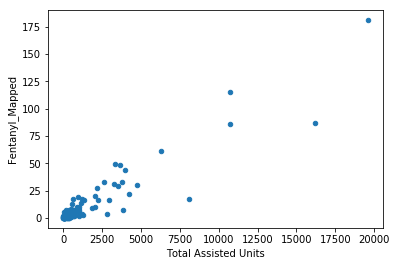

In [27]:
joined.plot(kind='scatter',x='Total Assisted Units', y = 'Fentanyl_Mapped')
# df.plot(kind='scatter', x='chol', y='weight', title="Cholesterol vs. Weight")

In [28]:
#http://www.portal.ct.gov/DPH/Health-Information-Systems--Reporting/Hisrhome/Hospitalization-Statistics
X = joined[['Total Assisted Units']]
y = joined[['Fentanyl_Mapped']]

### Split Data - Training data - train_test_split

In [29]:
# Split Data
# Now we can split our data into a training and test set.  In this example, we are using an 80/20 split, 
# where 80% of our data will be used for training our model, and 20% of our data will be used for testing.
    
from sklearn.model_selection import train_test_split

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) # test size 20%, random = True

### Training Model <br>
fit - learning a model<br>
X_train, Y_train = 80% of data

In [30]:
# Train Model
# Now we train our LinearRegression model using the training subset of data.

from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

model: <br> <t>y = a + b 


In [31]:
# Now that our model is trained, we can view the coefficients of the model using regression_model.coef_, 
# which is an array of tuples of coefficients.
# Each regression coefficient shows the strength of the relationship between the predictor variable and the
# outcome variable while controlling for the other predictor variable 

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for Total Assisted Units is 0.007762288365604705


y = a + 0.0233x

In [32]:
# regression_model.intercept_ returns an array of intercepts
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 0.6573820483062818


Now that we know the regression coefficient for our predictor variable and the intercept, we can figure out our model:

ŷ = 0.349 + 0.0233x


y = 0.349 + 0.0233(65)<br>
Predicted= xx<br>
Acutal =  xx



## How good is our model - the $R^{2}$ statistic

A common method of measuring the accuracy of regression models is to use the $R^{2}$ statistic.

The $R^{2}$ statistic is defined as follows:

$R^{2}$ =  1 – (RSS/TSS)

* The RSS (Residual sum of squares) measures the variability left unexplained after performing the regression
* The TSS measues the total variance in Y
* Therefore the $R^{2}$ statistic measures proportion of variability in Y that is explained by X using our model

The scale of $R^{2}$ statistic ranges from zero to one, with zero indicating that the proposed model **does not improve prediction over the mean model and one indicating perfect prediction**. Improvement in the regression model results in proportional increases in R-squared.

In [33]:
# R^2  can be determined using our test set and the model’s score method.

regression_model.score(X_test, y_test)

# This means that in our model, 95.7% of the variability in Y can be explained using X

0.64386072018837615

only predict numerical values (ordinal or ratio data)

### Focusing on the top five killers: 
<ul>
<li>Heroin</li>
<li>Fentanyl</li>
<li>Cocoine</li>
<li>Benzodiazepine</li>
<li>EtOH</li>
</ul>

## use Naive Bayes 

Contrubution of null results - no correlation is not useless. we are showing a dead end for other researchers - don't consider them.